<a href="https://colab.research.google.com/github/MariAgudelo2/Proyecto_KAGGLE/blob/main/03%20-%20preprocesado%20y%20SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia

 84% 25.0M/29.9M [00:00<00:00, 253MB/s]
100% 29.9M/29.9M [00:00<00:00, 242MB/s]


In [ ]:
!unzip udea*.zip > /dev/null

In [ ]:
!wc *.csv

   296787    296787   4716673 submission_example.csv
   296787   4565553  59185238 test.csv
   692501  10666231 143732437 train.csv
  1286075  15528571 207634348 total


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Preprocesamiento

In [ ]:
class SVMPreprocessing:

  def __init__(self, csv_file):
    self.z_copy = csv_file.copy()
    self.X_train = None
    self.X_test = None
    self.y_train = None
    self.y_test = None
    self.le = None
    self.scaler = None

  def inspect_data(self):
    print("Inspeccionando los datos...")
    self.z_copy.head()
    self.z_copy.info()
    self.z_copy.isnull().sum()

  def clean_data(self):
    print("Iniciando limpieza de datos (versión SVM)...")
    self.clean_privadolibertad_column()
    self.clean_tiene_columns()
    self.clean_valormatricula_column()
    self.clean_educacionpadres_columns()
    self.clean_estratovivienda_column()
    self.clean_horassemanatrabaja_column()
    self.clean_agrupar_programas_por_area()
    self.onehot_encoding_departamentos()

    print("Limpieza terminada")
    print(f"Shape final: {self.z_copy.shape}")

  def clean_privadolibertad_column(self):
    map_tiene = {'S': 1, 'N': 0}
    self.z_copy['E_PRIVADO_LIBERTAD'] = self.z_copy['E_PRIVADO_LIBERTAD'].map(map_tiene)

  def clean_tiene_columns(self):
    self.z_copy = self.z_copy.drop(['F_TIENEINTERNET.1'], axis=1)
    cols_tiene = [
        'F_TIENEINTERNET', 'F_TIENELAVADORA',
        'F_TIENEAUTOMOVIL', 'F_TIENECOMPUTADOR',
        'E_PAGOMATRICULAPROPIO'
    ]

    for col in cols_tiene:
        self.z_copy[col] = self.z_copy[col].fillna('No_info')

    map_tiene = {'Si': 1, 'No': 0, 'No_info': -1}

    for col in cols_tiene:
        self.z_copy[col] = self.z_copy[col].map(map_tiene)

  def clean_valormatricula_column(self):

    def convertir_rango_a_numero(valor):
      import re
      import unicodedata

      if pd.isna(valor):
          return np.nan

      texto = str(valor).lower()
      texto = ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn')

      if "no pago" in texto:
          return 0.0

      patrones = re.findall(r'(\d+\.?\d*)\s*(millon(?:es)?|mil)?', texto)
      numeros = []

      for num, unidad in patrones:
          n = float(num)
          if "millon" in unidad:
              n *= 1_000_000
          elif "mil" in unidad:
              n *= 1_000
          numeros.append(n)

      if len(numeros) == 2:
          return np.mean(numeros)

      if "menos de" in texto and len(numeros) == 1:
          return numeros[0] / 2

      if "mas de" in texto and len(numeros) == 1:
          return numeros[0] * 1.1

      return np.nan

    self.z_copy['E_VALORMATRICULAUNIVERSIDAD'] = self.z_copy['E_VALORMATRICULAUNIVERSIDAD'].apply(convertir_rango_a_numero)
    mediana = self.z_copy['E_VALORMATRICULAUNIVERSIDAD'].median()
    self.z_copy['E_VALORMATRICULAUNIVERSIDAD'] = self.z_copy['E_VALORMATRICULAUNIVERSIDAD'].fillna(mediana)

  def clean_educacionpadres_columns(self):
    from sklearn.preprocessing import OrdinalEncoder

    orden_educacion = [
        'sin info',
        'Primaria incompleta',
        'Primaria completa',
        'Secundaria (Bachillerato) incompleta',
        'Secundaria (Bachillerato) completa',
        'Técnica o tecnológica incompleta',
        'Técnica o tecnológica completa',
        'Educación profesional incompleta',
        'Educación profesional completa',
        'Postgrado'
    ]

    cols_to_clean = ['F_EDUCACIONMADRE', 'F_EDUCACIONPADRE']
    for col in cols_to_clean:
        self.z_copy[col] = self.z_copy[col].replace(['Ninguno', 'No Aplica', 'No sabe'], 'sin info')
        self.z_copy[col] = self.z_copy[col].fillna('sin info')

    encoder = OrdinalEncoder(categories=[orden_educacion, orden_educacion])
    self.z_copy[cols_to_clean] = encoder.fit_transform(self.z_copy[cols_to_clean])

  def clean_estratovivienda_column(self):
    self.z_copy['F_ESTRATOVIVIENDA'] = (
    self.z_copy['F_ESTRATOVIVIENDA']
    .astype(str)
    .replace(r'Estrato\s*(\d+)', r'\1', regex=True)
    .replace('Sin Estrato', 0)
    )

    self.z_copy['F_ESTRATOVIVIENDA'] = pd.to_numeric(self.z_copy['F_ESTRATOVIVIENDA'], errors='coerce')

    moda_estrato = self.z_copy['F_ESTRATOVIVIENDA'].mode()[0]
    self.z_copy['F_ESTRATOVIVIENDA'] = self.z_copy['F_ESTRATOVIVIENDA'].fillna(moda_estrato)

    self.z_copy['F_ESTRATOVIVIENDA'] = self.z_copy['F_ESTRATOVIVIENDA'].astype(int)

  def clean_horassemanatrabaja_column(self):
    mapa_horas = {
    '0': 0,
    'Menos de 10 horas': 5,
    'Entre 11 y 20 horas': 15,
    'Entre 21 y 30 horas': 25,
    'Más de 30 horas': 35
    }

    self.z_copy['E_HORASSEMANATRABAJA'] = self.z_copy['E_HORASSEMANATRABAJA'].replace(mapa_horas)
    self.z_copy['E_HORASSEMANATRABAJA'] = pd.to_numeric(self.z_copy['E_HORASSEMANATRABAJA'], errors='coerce')

    mediana_horas = self.z_copy['E_HORASSEMANATRABAJA'].median()
    self.z_copy['E_HORASSEMANATRABAJA'] = self.z_copy['E_HORASSEMANATRABAJA'].fillna(mediana_horas)

  def clean_agrupar_programas_por_area(self):
    """Agrupa los programas académicos en áreas generales"""

    areas_dict = {
        'INGENIERIA': ['INGENIER', 'INGENER'],
        'SALUD': ['MEDICINA', 'ENFERMERIA', 'ODONTOLOGIA', 'FISIOTERAPIA',
                  'TERAPIA', 'NUTRICION', 'OPTOMETRIA', 'FONOAUDIOLOGIA',
                  'INSTRUMENTACION QUIRURGICA', 'BACTERIOLOGIA'],
        'ADMINISTRACION': ['ADMINISTR', 'GESTION', 'GERENCIA', 'NEGOCIOS',
                           'COMERCIO', 'FINANZAS', 'MERCADEO', 'MARKETING',
                           'LOGISTICA', 'BANCA'],
        'EDUCACION': ['LICENCIATURA', 'PEDAGOGIA', 'EDUCACION'],
        'ARTES': ['ARTE', 'DISEÑO', 'DISE', 'MUSICA', 'DANZA', 'TEATRO',
                  'CINE', 'FOTOGRAFIA', 'AUDIOVISUAL'],
        'CIENCIAS_SOCIALES': ['DERECHO', 'PSICOLOGIA', 'SOCIOLOGIA',
                              'TRABAJO SOCIAL', 'ANTROPOLOGIA', 'FILOSOFIA',
                              'CIENCIA POLITICA', 'RELACIONES INTERNACIONALES'],
        'COMUNICACION': ['COMUNICACION', 'PERIODISMO', 'PUBLICIDAD'],
        'CIENCIAS_EXACTAS': ['MATEMATICA', 'FISICA', 'QUIMICA', 'BIOLOGIA',
                             'ESTADISTICA', 'ASTRONOMIA'],
        'AGRONOMIA': ['AGRO', 'VETERINARIA', 'ZOOTECNIA', 'PECUARIA'],
        'ARQUITECTURA': ['ARQUITECTURA', 'URBANISMO', 'CONSTRUCCION']
    }

    def clasificar_programa(programa):
        programa_upper = str(programa).upper()

        for area, keywords in areas_dict.items():
            if any(keyword in programa_upper for keyword in keywords):
                return area

        return 'OTRAS'

    self.z_copy['AREA_CONOCIMIENTO'] = self.z_copy['E_PRGM_ACADEMICO'].apply(clasificar_programa)

    area_dummies = pd.get_dummies(
        self.z_copy['AREA_CONOCIMIENTO'],
        prefix='area',
        drop_first=True
    ).astype(int)

    self.z_copy = pd.concat([self.z_copy, area_dummies], axis=1)
    print(f"Programas agrupados en {self.z_copy['AREA_CONOCIMIENTO'].nunique()} áreas")

  def onehot_encoding_departamentos(self):
    depto_dummies = pd.get_dummies(
        self.z_copy['E_PRGM_DEPARTAMENTO'],
        prefix='depto',
        drop_first=True
    ).astype(int)

    self.z_copy = pd.concat([self.z_copy, depto_dummies], axis=1)

  def create_features(self):
    #Crea features adicionales + interacciones que son útiles para SVM

    # Features originales del RF
    self.z_copy['F_EDUCACION_PROMEDIO_PADRES'] = (
        self.z_copy['F_EDUCACIONPADRE'] + self.z_copy['F_EDUCACIONMADRE']
    ) / 2

    self.z_copy['F_RECURSOS_HOGAR'] = (
        self.z_copy['F_TIENEINTERNET'] +
        self.z_copy['F_TIENECOMPUTADOR'] +
        self.z_copy['F_TIENELAVADORA'] +
        self.z_copy['F_TIENEAUTOMOVIL']
    )

    self.z_copy['E_CARGA_TRABAJO'] = self.z_copy['E_HORASSEMANATRABAJA'] / 40

    # NUEVAS FEATURES para SVM

    # Interacción: educación de padres con recursos del hogar
    self.z_copy['F_EDUC_X_RECURSOS'] = (
        self.z_copy['F_EDUCACION_PROMEDIO_PADRES'] * self.z_copy['F_RECURSOS_HOGAR']
    )

    # Indicador de situación socioeconómica combinada
    self.z_copy['F_NIVEL_SOCIOECONOMICO'] = (
        self.z_copy['F_ESTRATOVIVIENDA'] +
        (self.z_copy['F_RECURSOS_HOGAR'] / 4) * 6  # Normalizado a escala 0-6
    ) / 2

    # Indicador de apoyo educativo familiar
    self.z_copy['F_APOYO_EDUCATIVO'] = (
        (self.z_copy['F_TIENEINTERNET'] > 0).astype(int) +
        (self.z_copy['F_TIENECOMPUTADOR'] > 0).astype(int) +
        (self.z_copy['F_EDUCACION_PROMEDIO_PADRES'] > 5).astype(int)
    )

    # Matrícula vs estrato (accesibilidad económica)
    # Evitamos división por cero
    estrato_safe = self.z_copy['F_ESTRATOVIVIENDA'].replace(0, 0.5)
    self.z_copy['E_RATIO_MATRICULA_ESTRATO'] = (
        self.z_copy['E_VALORMATRICULAUNIVERSIDAD'] / (estrato_safe * 1_000_000)
    )

    # Indicador de esfuerzo propio (paga matrícula + trabaja)
    self.z_copy['E_ESFUERZO_PROPIO'] = (
        (self.z_copy['E_PAGOMATRICULAPROPIO'] > 0).astype(int) +
        (self.z_copy['E_HORASSEMANATRABAJA'] > 20).astype(int)
    )

    print(f"Features creadas (incluyendo interacciones). Shape actual: {self.z_copy.shape}")

  def apply_svm(self, sample_size=50000):

    from sklearn.svm import SVC
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    print("="*70)
    print("ENTRENANDO MODELO SVM CON MUESTREO")
    print("="*70)

    # Preparar datos
    self.le = LabelEncoder()
    y = self.le.fit_transform(self.z_copy['RENDIMIENTO_GLOBAL'])

    X = self.z_copy.drop([
        'ID', 'RENDIMIENTO_GLOBAL', 'E_PRGM_ACADEMICO',
        'E_PRGM_DEPARTAMENTO', 'AREA_CONOCIMIENTO'
    ], axis=1)

    # MUESTREO ESTRATIFICADO para reducir tiempo de entrenamiento
    if len(X) > sample_size:
        print(f"\n Aplicando muestreo estratificado: {len(X)} → {sample_size} muestras")
        from sklearn.model_selection import train_test_split
        X_sample, _, y_sample, _ = train_test_split(
            X, y,
            train_size=sample_size,
            random_state=42,
            stratify=y
        )
        X, y = X_sample, y_sample
        print(f" Muestreo completado: {X.shape}")

    # Split
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"\nTraining set size: {self.X_train.shape}")
    print(f"Test set size: {self.X_test.shape}")
    print(f"\nDistribución de clases en entrenamiento:")
    unique, counts = np.unique(self.y_train, return_counts=True)
    for cls, cnt in zip(unique, counts):
        print(f"  Clase {self.le.classes_[cls]}: {cnt} ({cnt/len(self.y_train)*100:.2f}%)")

    # CRUCIAL: Escalar datos para SVM
    print("\nEscalando features con StandardScaler...")
    self.scaler = StandardScaler()
    X_train_scaled = self.scaler.fit_transform(self.X_train)
    X_test_scaled = self.scaler.transform(self.X_test)

    # Modelo SVM con kernel RBF
    print("\nEntrenando SVM con kernel RBF...")

    svm_model = SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        class_weight='balanced',
        random_state=42,
        cache_size=1000,  # Aumentar cache para velocidad
        verbose=False     # Desactivar verbose para limpieza
    )

    import time
    start = time.time()
    svm_model.fit(X_train_scaled, self.y_train)
    elapsed = time.time() - start
    print(f" Entrenamiento completado en {elapsed:.1f} segundos")

    # Predicciones
    y_pred_svm = svm_model.predict(X_test_scaled)

    # Resultados
    print("\n" + "="*70)
    print("RESULTADOS SVM")
    print("="*70)
    print(f"Accuracy: {accuracy_score(self.y_test, y_pred_svm):.4f}")
    print("\nReporte de Clasificación:")
    print(classification_report(self.y_test, y_pred_svm,
                              target_names=self.le.classes_))

    # Matriz de confusión
    cm_svm = confusion_matrix(self.y_test, y_pred_svm)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
                xticklabels=self.le.classes_, yticklabels=self.le.classes_)
    plt.title('Matriz de Confusión - SVM (RBF Kernel)')
    plt.ylabel('Real')
    plt.xlabel('Predicción')
    plt.tight_layout()
    plt.show()

    return svm_model

  def predict_test_set(self, test_csv_path, model, output_path='predicciones.csv'):
    print("="*70)
    print("PROCESANDO TEST SET Y GENERANDO PREDICCIONES")
    print("="*70)

    # Cargar test.csv
    test_df = pd.read_csv(test_csv_path)
    print(f"Test set cargado: {test_df.shape}")

    # Guardar IDs originales
    test_ids = test_df['ID'].copy()

    # Crear copia para procesar
    test_processed = test_df.copy()

    # Aplicar el MISMO preprocesamiento que al training
    print("\nAplicando preprocesamiento...")
    test_processed = self._preprocess_test_data(test_processed)

    # Asegurarse de que tenga las mismas columnas que el training
    # (menos las que se eliminaron: ID, RENDIMIENTO_GLOBAL, etc.)
    training_columns = self.X_train.columns

    # Agregar columnas faltantes con 0s (por si algún departamento/área no aparece en test)
    for col in training_columns:
        if col not in test_processed.columns:
            test_processed[col] = 0

    # Mantener solo las columnas del training en el mismo orden
    test_processed = test_processed[training_columns]

    print(f"Test procesado: {test_processed.shape}")
    print(f"Training shape: {self.X_train.shape}")

    # Escalar con el MISMO scaler del entrenamiento
    print("\nEscalando test set...")
    if self.scaler is None:
        raise ValueError("scaler no encontrado")

    test_scaled = self.scaler.transform(test_processed)

    # Predecir
    print("Generando predicciones...")
    y_pred = model.predict(test_scaled)

    # Convertir predicciones numéricas a etiquetas originales
    y_pred_labels = self.le.inverse_transform(y_pred)

    # Crear DataFrame de resultados
    results = pd.DataFrame({
        'ID': test_ids,
        'RENDIMIENTO_GLOBAL': y_pred_labels
    })

    # Guardar a CSV
    results.to_csv(output_path, index=False)
    print(f"\n Predicciones guardadas en: {output_path}")
    print(f"Total predicciones: {len(results)}")
    print(f"\nDistribución de predicciones:")
    print(results['RENDIMIENTO_GLOBAL'].value_counts())

    return results

  def _preprocess_test_data(self, test_df):

    # Aplicar todas las transformaciones (excepto las que usan info del target)

    # 1. Privado libertad
    map_tiene = {'S': 1, 'N': 0}
    test_df['E_PRIVADO_LIBERTAD'] = test_df['E_PRIVADO_LIBERTAD'].map(map_tiene)

    # 2. Columnas "tiene"
    if 'F_TIENEINTERNET.1' in test_df.columns:
        test_df = test_df.drop(['F_TIENEINTERNET.1'], axis=1)

    cols_tiene = ['F_TIENEINTERNET', 'F_TIENELAVADORA',
                  'F_TIENEAUTOMOVIL', 'F_TIENECOMPUTADOR',
                  'E_PAGOMATRICULAPROPIO']

    for col in cols_tiene:
        if col in test_df.columns:
            test_df[col] = test_df[col].fillna('No_info')

    map_tiene = {'Si': 1, 'No': 0, 'No_info': -1}
    for col in cols_tiene:
        if col in test_df.columns:
            test_df[col] = test_df[col].map(map_tiene)

    # 3. Valor matrícula (usar la MISMA mediana del train)
    def convertir_rango_a_numero(valor):
        import re
        import unicodedata

        if pd.isna(valor):
            return np.nan

        texto = str(valor).lower()
        texto = ''.join(c for c in unicodedata.normalize('NFD', texto)
                       if unicodedata.category(c) != 'Mn')

        if "no pago" in texto:
            return 0.0

        patrones = re.findall(r'(\d+\.?\d*)\s*(millon(?:es)?|mil)?', texto)
        numeros = []

        for num, unidad in patrones:
            n = float(num)
            if "millon" in unidad:
                n *= 1_000_000
            elif "mil" in unidad:
                n *= 1_000
            numeros.append(n)

        if len(numeros) == 2:
            return np.mean(numeros)
        if "menos de" in texto and len(numeros) == 1:
            return numeros[0] / 2
        if "mas de" in texto and len(numeros) == 1:
            return numeros[0] * 1.1

        return np.nan

    if 'E_VALORMATRICULAUNIVERSIDAD' in test_df.columns:
        test_df['E_VALORMATRICULAUNIVERSIDAD'] = test_df['E_VALORMATRICULAUNIVERSIDAD'].apply(convertir_rango_a_numero)
        # Usar la mediana del TRAIN, no del test
        mediana_train = self.z_copy['E_VALORMATRICULAUNIVERSIDAD'].median()
        test_df['E_VALORMATRICULAUNIVERSIDAD'] = test_df['E_VALORMATRICULAUNIVERSIDAD'].fillna(mediana_train)

    # 4. Educación padres
    from sklearn.preprocessing import OrdinalEncoder

    orden_educacion = [
        'sin info', 'Primaria incompleta', 'Primaria completa',
        'Secundaria (Bachillerato) incompleta', 'Secundaria (Bachillerato) completa',
        'Técnica o tecnológica incompleta', 'Técnica o tecnológica completa',
        'Educación profesional incompleta', 'Educación profesional completa', 'Postgrado'
    ]

    cols_to_clean = ['F_EDUCACIONMADRE', 'F_EDUCACIONPADRE']
    for col in cols_to_clean:
        if col in test_df.columns:
            test_df[col] = test_df[col].replace(['Ninguno', 'No Aplica', 'No sabe'], 'sin info')
            test_df[col] = test_df[col].fillna('sin info')

    encoder = OrdinalEncoder(categories=[orden_educacion, orden_educacion])
    if all(col in test_df.columns for col in cols_to_clean):
        test_df[cols_to_clean] = encoder.fit_transform(test_df[cols_to_clean])

    # 5. Estrato
    if 'F_ESTRATOVIVIENDA' in test_df.columns:
        test_df['F_ESTRATOVIVIENDA'] = (
            test_df['F_ESTRATOVIVIENDA']
            .astype(str)
            .replace(r'Estrato\s*(\d+)', r'\1', regex=True)
            .replace('Sin Estrato', 0)
        )
        test_df['F_ESTRATOVIVIENDA'] = pd.to_numeric(test_df['F_ESTRATOVIVIENDA'], errors='coerce')
        moda_train = self.z_copy['F_ESTRATOVIVIENDA'].mode()[0]
        test_df['F_ESTRATOVIVIENDA'] = test_df['F_ESTRATOVIVIENDA'].fillna(moda_train)
        test_df['F_ESTRATOVIVIENDA'] = test_df['F_ESTRATOVIVIENDA'].astype(int)

    # 6. Horas trabajo
    mapa_horas = {
        '0': 0, 'Menos de 10 horas': 5, 'Entre 11 y 20 horas': 15,
        'Entre 21 y 30 horas': 25, 'Más de 30 horas': 35
    }
    if 'E_HORASSEMANATRABAJA' in test_df.columns:
        test_df['E_HORASSEMANATRABAJA'] = test_df['E_HORASSEMANATRABAJA'].replace(mapa_horas)
        test_df['E_HORASSEMANATRABAJA'] = pd.to_numeric(test_df['E_HORASSEMANATRABAJA'], errors='coerce')
        mediana_train = self.z_copy['E_HORASSEMANATRABAJA'].median()
        test_df['E_HORASSEMANATRABAJA'] = test_df['E_HORASSEMANATRABAJA'].fillna(mediana_train)

    # 7. Agrupar programas
    areas_dict = {
        'INGENIERIA': ['INGENIER', 'INGENER'],
        'SALUD': ['MEDICINA', 'ENFERMERIA', 'ODONTOLOGIA', 'FISIOTERAPIA',
                  'TERAPIA', 'NUTRICION', 'OPTOMETRIA', 'FONOAUDIOLOGIA',
                  'INSTRUMENTACION QUIRURGICA', 'BACTERIOLOGIA'],
        'ADMINISTRACION': ['ADMINISTR', 'GESTION', 'GERENCIA', 'NEGOCIOS',
                           'COMERCIO', 'FINANZAS', 'MERCADEO', 'MARKETING',
                           'LOGISTICA', 'BANCA'],
        'EDUCACION': ['LICENCIATURA', 'PEDAGOGIA', 'EDUCACION'],
        'ARTES': ['ARTE', 'DISEÑO', 'DISE', 'MUSICA', 'DANZA', 'TEATRO',
                  'CINE', 'FOTOGRAFIA', 'AUDIOVISUAL'],
        'CIENCIAS_SOCIALES': ['DERECHO', 'PSICOLOGIA', 'SOCIOLOGIA',
                              'TRABAJO SOCIAL', 'ANTROPOLOGIA', 'FILOSOFIA',
                              'CIENCIA POLITICA', 'RELACIONES INTERNACIONALES'],
        'COMUNICACION': ['COMUNICACION', 'PERIODISMO', 'PUBLICIDAD'],
        'CIENCIAS_EXACTAS': ['MATEMATICA', 'FISICA', 'QUIMICA', 'BIOLOGIA',
                             'ESTADISTICA', 'ASTRONOMIA'],
        'AGRONOMIA': ['AGRO', 'VETERINARIA', 'ZOOTECNIA', 'PECUARIA'],
        'ARQUITECTURA': ['ARQUITECTURA', 'URBANISMO', 'CONSTRUCCION']
    }

    def clasificar_programa(programa):
        programa_upper = str(programa).upper()
        for area, keywords in areas_dict.items():
            if any(keyword in programa_upper for keyword in keywords):
                return area
        return 'OTRAS'

    if 'E_PRGM_ACADEMICO' in test_df.columns:
        test_df['AREA_CONOCIMIENTO'] = test_df['E_PRGM_ACADEMICO'].apply(clasificar_programa)
        area_dummies = pd.get_dummies(test_df['AREA_CONOCIMIENTO'], prefix='area', drop_first=True).astype(int)
        test_df = pd.concat([test_df, area_dummies], axis=1)

    # 8. One-hot departamento
    if 'E_PRGM_DEPARTAMENTO' in test_df.columns:
        depto_dummies = pd.get_dummies(test_df['E_PRGM_DEPARTAMENTO'], prefix='depto', drop_first=True).astype(int)
        test_df = pd.concat([test_df, depto_dummies], axis=1)

    # 9. Features adicionales
    if 'F_EDUCACIONPADRE' in test_df.columns and 'F_EDUCACIONMADRE' in test_df.columns:
        test_df['F_EDUCACION_PROMEDIO_PADRES'] = (test_df['F_EDUCACIONPADRE'] + test_df['F_EDUCACIONMADRE']) / 2

    if all(col in test_df.columns for col in ['F_TIENEINTERNET', 'F_TIENECOMPUTADOR', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL']):
        test_df['F_RECURSOS_HOGAR'] = (
            test_df['F_TIENEINTERNET'] + test_df['F_TIENECOMPUTADOR'] +
            test_df['F_TIENELAVADORA'] + test_df['F_TIENEAUTOMOVIL']
        )

    if 'E_HORASSEMANATRABAJA' in test_df.columns:
        test_df['E_CARGA_TRABAJO'] = test_df['E_HORASSEMANATRABAJA'] / 40

    if 'F_EDUCACION_PROMEDIO_PADRES' in test_df.columns and 'F_RECURSOS_HOGAR' in test_df.columns:
        test_df['F_EDUC_X_RECURSOS'] = test_df['F_EDUCACION_PROMEDIO_PADRES'] * test_df['F_RECURSOS_HOGAR']

    if 'F_ESTRATOVIVIENDA' in test_df.columns and 'F_RECURSOS_HOGAR' in test_df.columns:
        test_df['F_NIVEL_SOCIOECONOMICO'] = (test_df['F_ESTRATOVIVIENDA'] + (test_df['F_RECURSOS_HOGAR'] / 4) * 6) / 2

    if all(col in test_df.columns for col in ['F_TIENEINTERNET', 'F_TIENECOMPUTADOR', 'F_EDUCACION_PROMEDIO_PADRES']):
        test_df['F_APOYO_EDUCATIVO'] = (
            (test_df['F_TIENEINTERNET'] > 0).astype(int) +
            (test_df['F_TIENECOMPUTADOR'] > 0).astype(int) +
            (test_df['F_EDUCACION_PROMEDIO_PADRES'] > 5).astype(int)
        )

    if 'E_VALORMATRICULAUNIVERSIDAD' in test_df.columns and 'F_ESTRATOVIVIENDA' in test_df.columns:
        estrato_safe = test_df['F_ESTRATOVIVIENDA'].replace(0, 0.5)
        test_df['E_RATIO_MATRICULA_ESTRATO'] = test_df['E_VALORMATRICULAUNIVERSIDAD'] / (estrato_safe * 1_000_000)

    if 'E_PAGOMATRICULAPROPIO' in test_df.columns and 'E_HORASSEMANATRABAJA' in test_df.columns:
        test_df['E_ESFUERZO_PROPIO'] = (
            (test_df['E_PAGOMATRICULAPROPIO'] > 0).astype(int) +
            (test_df['E_HORASSEMANATRABAJA'] > 20).astype(int)
        )

    # Eliminar columnas originales que no se usan en el modelo
    cols_to_drop = ['ID', 'E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO', 'AREA_CONOCIMIENTO']
    test_df = test_df.drop([col for col in cols_to_drop if col in test_df.columns], axis=1)

    return test_df

## Entrenamiento del modelo

Iniciando limpieza de datos (versión SVM)...


/tmp/ipython-input-3205072408.py:141: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.z_copy['E_HORASSEMANATRABAJA'] = self.z_copy['E_HORASSEMANATRABAJA'].replace(mapa_horas)


Programas agrupados en 11 áreas
Limpieza terminada
Shape final: (692500, 61)
Features creadas (incluyendo interacciones). Shape actual: (692500, 69)
ENTRENANDO MODELO SVM CON MUESTREO

 Aplicando muestreo estratificado: 692500 → 50000 muestras
 Muestreo completado: (50000, 64)

Training set size: (40000, 64)
Test set size: (10000, 64)

Distribución de clases en entrenamiento:
  Clase alto: 10144 (25.36%)
  Clase bajo: 9992 (24.98%)
  Clase medio-alto: 9913 (24.78%)
  Clase medio-bajo: 9951 (24.88%)

Escalando features con StandardScaler...

Entrenando SVM con kernel RBF...
 Entrenamiento completado en 317.8 segundos

RESULTADOS SVM
Accuracy: 0.3929

Reporte de Clasificación:
              precision    recall  f1-score   support

        alto       0.52      0.57      0.54      2536
        bajo       0.41      0.46      0.43      2498
  medio-alto       0.29      0.23      0.26      2478
  medio-bajo       0.31      0.31      0.31      2488

    accuracy                           0.39 

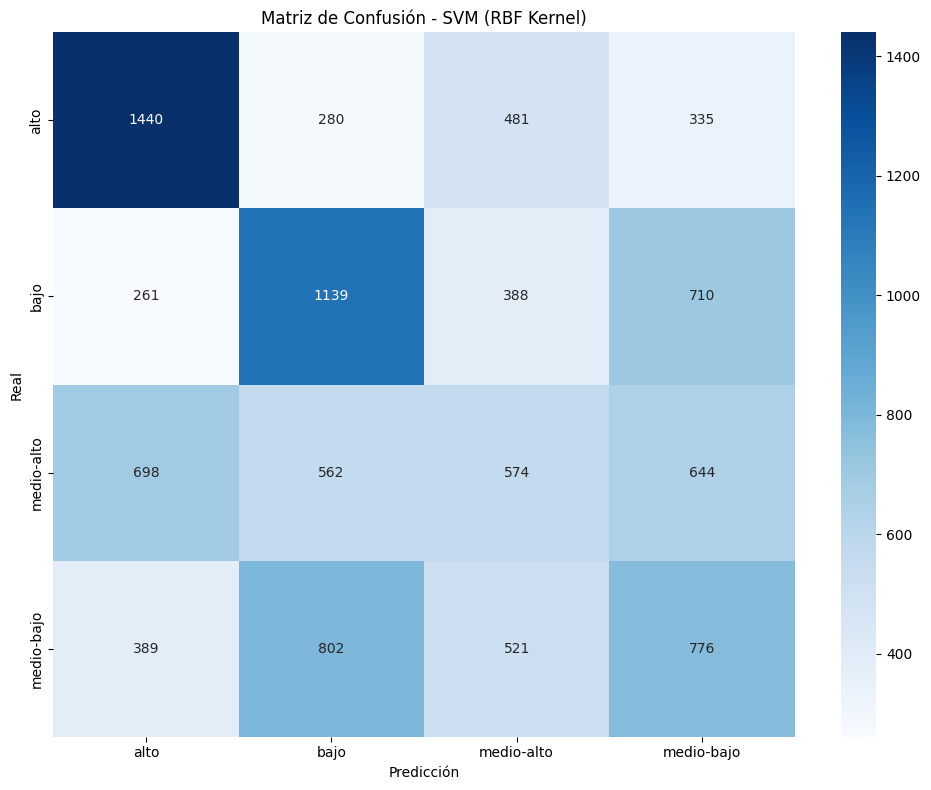

In [ ]:
z = pd.read_csv('train.csv')
svm_prep = SVMPreprocessing(z)

svm_prep.clean_data()
svm_prep.create_features()
modelo = svm_prep.apply_svm()

#Prueba con Test.csv

In [ ]:
predicciones = svm_prep.predict_test_set(
    test_csv_path='test.csv',
    model=modelo,
    output_path='mis_predicciones.csv'
)

print(predicciones.head())

PROCESANDO TEST SET Y GENERANDO PREDICCIONES
Test set cargado: (296786, 20)

Aplicando preprocesamiento...


/tmp/ipython-input-3205072408.py:517: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df['E_HORASSEMANATRABAJA'] = test_df['E_HORASSEMANATRABAJA'].replace(mapa_horas)


Test procesado: (296786, 64)
Training shape: (40000, 64)

Escalando test set...
Generando predicciones...
